# WaffleHacks 2022 - Computational Imaging Workshop - Image Blending
#### Instructed by Kevin Gauld, images for explanatory part largely sourced from [here](https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f)

#### Also for another good presentation with more applications see [here](http://graphics.cs.cmu.edu/courses/15-463/2005_fall/www/Lectures/Pyramids.pdf)


## What is image blending?

<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987841504045322270/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987841643224903750/unknown.png" width="500">

</div>


## Gaussian Pyramids


<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987842317769666700/unknown.png" width="500">
</div>

### Effective Downsampling

<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987843367176138884/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987839037836496956/unknown.png" width="500">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987842748071673876/unknown.png" width="500">

</div>

### Results for apple and orange


<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987844582421184523/unknown.png" width="800">

</div>


## Laplacian Pyramid

<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987845301681401927/unknown.png" width="800">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987845385827516416/unknown.png" width="600">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987845617512501248/unknown.png" width="1000">
</div>


## Blending!!

<div>
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987846820803805254/unknown.png" width="800">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987846884930494504/unknown.png" width="1000">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987847038467194920/unknown.png" width="1000">
    <img src="https://cdn.discordapp.com/attachments/730567294102667324/987847154657808414/unknown.png" width="1000">
</div>


# Implement blending!!

In [161]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [241]:
def resize(image: np.ndarray, size) -> np.ndarray:
    '''
    Convert an image to the specified size (height, width) using bicubic
    interpolation.
    '''
    return _resize_channel(image, size) if image.ndim == 2 else np.dstack([
        _resize_channel(chan, size) for chan in image.transpose(2, 0, 1)
    ])

def _resize_channel(chan: np.ndarray, size) -> np.ndarray:
    '''
    Resize a single image channel using bicubic interpolation
    '''
    return np.asarray(Image.fromarray(chan).resize(size[::-1], Image.Resampling.BICUBIC))

def norm_img(img) -> np.ndarray:
    '''
    Normalize a given image (scale from [min, max] to [0,1])
    '''
    return (img - np.min(img))/np.ptp(img)

def pyrUp(img, shape) -> np.ndarray:
    '''
    Return an upscaled version of the given image with a desired output shape
    '''
    pyrup = cv2.pyrUp(img)
    return resize(img,shape)

def show_image(img, ticks=False):
    '''
    Display an image with or without axis ticks, and rescale if necessary
    '''
    if not ticks:
        plt.xticks([])
        plt.yticks([])

    imtoshow = img
    if np.min(img) < 0 or np.max(img) > 1:
        imtoshow = norm_img(img)

    plt.imshow(imtoshow)

def show_pyramid(pyr, ticks=True):
    '''
    Display a given image pyramid
    '''
    plt.figure(figsize=(15,15))
    for i in range(len(pyr)):
        plt.subplot(1, len(pyr), i+1)
        plt.grid(False)
        show_image(pyr[i], ticks=ticks)

    plt.show()

# Read in Images

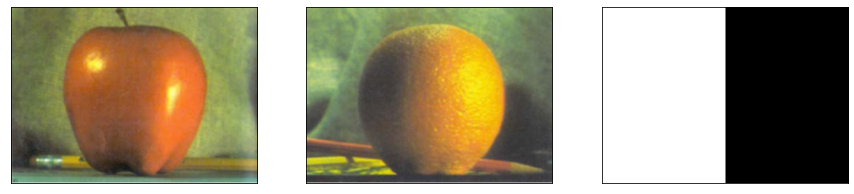

In [243]:
A = cv2.imread('A.png')[:,:,::-1]/255.0
B = cv2.imread('B.png')[:,:,::-1]/255.0
mask = cv2.imread('M.png')[:,:,::-1]/255.0

show_pyramid([A,B,mask], ticks=False)

# Compute the Gaussian Pyramid

In [244]:
def gaussian_pyramid(img, level):
    pyr = [img.copy()]
    for _ in range(level-1):
        pyr.append(cv2.pyrDown(pyr[-1]))
    return pyr

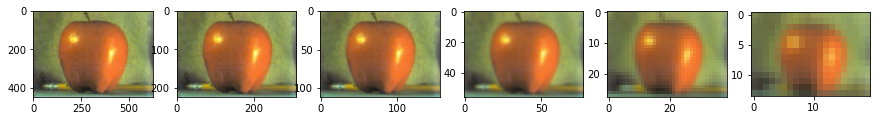

In [245]:
A_pyr = gaussian_pyramid(A, 6)
show_pyramid(A_pyr, ticks=True)

# Compute the Laplacian Pyramid

In [246]:
def laplacian_pyramid(img, level):
    gauss_pyr = gaussian_pyramid(img, level)
    l_pyr = [gauss_pyr[-1]]
    for k in range(level-1, 0, -1):
        pyr_up = pyrUp(gauss_pyr[k], gauss_pyr[k-1].shape[0:2])
        l_pyr.append(gauss_pyr[k-1]-pyr_up)
    l_pyr.reverse()
    return l_pyr

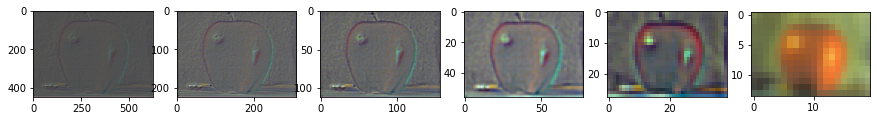

In [247]:
A_pyr = laplacian_pyramid(A, 6)
show_pyramid(A_pyr, ticks=True)

# Rebuild an image from the Laplacian Pyramid

In [248]:
def rebuild_pyramid(pyr):
    res = np.zeros(pyr[-1].shape)
    for k in range(len(pyr), 0, -1):
        res = pyrUp(res,pyr[k-1].shape[:2]) + pyr[k-1]
    return res

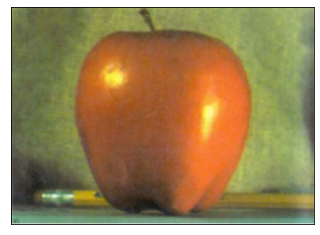

In [249]:
img = rebuild_pyramid(A_pyr)
show_image(img)

# Create a blended pyramid

In [250]:
def blend_pyramid(imgA, imgB, mask, level):
    lpyr_A = laplacian_pyramid(imgA,level)
    lpyr_B = laplacian_pyramid(imgB,level)
    gpyr_M = gaussian_pyramid(mask,level)
    new_pyr = [None]*level
    
    for k in range(level):
        new_pyr[k] = lpyr_A[k]*gpyr_M[k] + lpyr_B[k]*(1-gpyr_M[k])
    
    return new_pyr

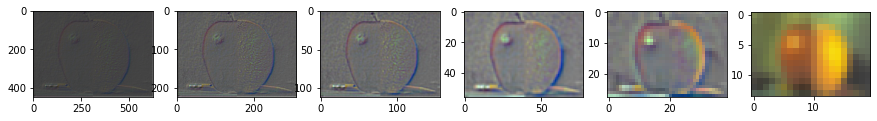

In [251]:
blend_pyr = blend_pyramid(A, B, mask, 6)
show_pyramid(blend_pyr, ticks=True)

# Blend two images using the blend pyramid

In [252]:
def blend(imgA, imgB, mask, level):
    pyr = blend_pyramid(imgA, imgB, mask, level)
    blended_img = rebuild_pyramid(pyr)
    return blended_img

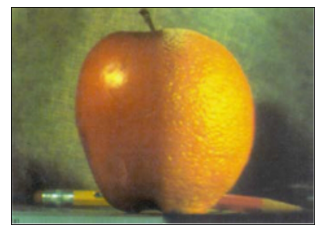

In [253]:
img = norm_img(blend(A,B,mask,6))
show_image(img)

# Custom mask

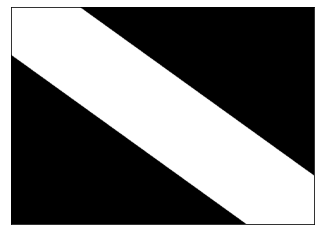

In [256]:
newmask = np.zeros(mask.shape)


for k in range(len(newmask)):
    for i in range(len(newmask[k])):
        r = len(newmask)/len(newmask[k])
        if abs(k-r*i) < 100:
            newmask[k,i,:] = [1,1,1]

show_image(newmask)

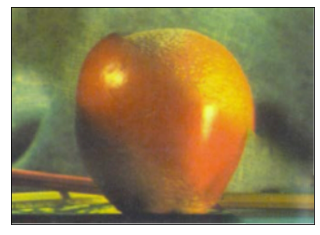

In [257]:
img = norm_img(blend(A,B,newmask,6))
show_image(img)